In [1]:
# !pip install pympler
# !pip install geopy

In [2]:
import re
import math
import geopy
from pympler import asizeof

In [3]:
class Time:
    def __init__(self, h=0, m=0):
        self.hours = h
        self.minutes = m

    # --- Часы ---
    @property
    def hours(self):
        return self.__h

    @hours.setter
    def hours(self, h):
        if 0 <= h < 24:
            self.__h = h
        else:
            raise ValueError("Часы должны быть в диапазоне 0–23")

    # --- Минуты ---
    @property
    def minutes(self):
        return self.__m

    @minutes.setter
    def minutes(self, m):
        if 0 <= m < 60:
            self.__m = m
        else:
            raise ValueError("Минуты должны быть в диапазоне 0–59")

    # --- Представление ---
    def __str__(self):
        return f"{self.__h:02d}:{self.__m:02d}"

    def __repr__(self):
        return f"Time({self.__h}, {self.__m})"

    # --- Вспомогательные методы ---
    def to_minutes(self):
        return self.__h * 60 + self.__m

    # --- Среднее ---
    @staticmethod
    def average(times):
        if not times:
            raise ValueError("Список времени пуст")
        avg_minutes = sum(t.to_minutes() for t in times) / len(times)
        return Time.from_minutes(round(avg_minutes))
    
    @staticmethod
    def from_minutes(total_minutes):
        total_minutes %= 24 * 60  # цикл по суткам
        h = total_minutes // 60
        m = total_minutes % 60
        return Time(h, m)

    # --- Хэш и равенство ---
    def __hash__(self):
        return hash((self.__h, self.__m))

    def __eq__(self, other):
        if not isinstance(other, Time):
            return NotImplemented
        return self.to_minutes() == other.to_minutes()
    
    # --- Операторы сравнения ---
    def __lt__(self, other):
        if not isinstance(other, Time): return NotImplemented
        return self.to_minutes() < other.to_minutes()

    def __le__(self, other):
        if not isinstance(other, Time): return NotImplemented
        return self.to_minutes() <= other.to_minutes()

    def __gt__(self, other):
        if not isinstance(other, Time): return NotImplemented
        return self.to_minutes() > other.to_minutes()

    def __ge__(self, other):
        if not isinstance(other, Time): return NotImplemented
        return self.to_minutes() >= other.to_minutes()

    # --- Арифметика ---
    def __add__(self, other):
        if isinstance(other, Time):
            total = self.to_minutes() + other.to_minutes()
        elif isinstance(other, int):
            total = self.to_minutes() + other
        else:
            return NotImplemented
        return Time.from_minutes(total)

    def __sub__(self, other):
        if isinstance(other, Time):
            diff = self.to_minutes() - other.to_minutes()
        elif isinstance(other, int):
            diff = self.to_minutes() - other
        else:
            return NotImplemented
        return Time.from_minutes(diff)

    def __truediv__(self, n):
        if not isinstance(n, (int, float)):
            return NotImplemented
        return Time.from_minutes(round(self.to_minutes() / n))

In [4]:
def parseCoordinates(coord_str):
	"""
	Парсит координаты в формате:
	28°40′00″ с. ш. 77°13′00″ в. д.
	Возвращает (latitude, longitude) в виде float.
	"""
	pattern = r"(\d+)°(\d+)′(\d+)″\s*([сСюЮ]\.\s*ш\.)\s*(\d+)°(\d+)′(\d+)″\s*([вВзЗ]\.\s*д\.)"
	match = re.search(pattern, coord_str.strip())
	if not match:
		raise ValueError("Неверный формат координат. Ожидается '28°40′00″ с. ш. 77°13′00″ в. д.'")

	# Извлекаем значения
	lat_deg, lat_min, lat_sec, lat_dir, lon_deg, lon_min, lon_sec, lon_dir = match.groups()

	# Переводим в радианы
	lat = math.radians(int(lat_deg) + int(lat_min) / 60 + int(lat_sec) / 3600)
	lon = math.radians(int(lon_deg) + int(lon_min) / 60 + int(lon_sec) / 3600)

	# Определяем знак (север/юг, восток/запад)
	if "ю" in lat_dir.lower():
		lat = -lat
	if "з" in lon_dir.lower():
		lon = -lon

	return lat, lon

In [5]:
class City:
    def __init__(self, title="", republic="", 
                 lat=None, lon=None, coordStr=None, 
                 timeZone=None,
                 sunriseTime=None, sunsetTime=None,
                 isCapital=False, populationDensity=0):

        self.title = title
        self.republic = republic

        if coordStr:
            lat, lon = parseCoordinates(coordStr)

        # protected-сеттеры
        self._set_lat(lat if lat else 0)
        self._set_lon(lon if lon else 0)
        self._set_timeZone(timeZone if timeZone else Time())
        self._set_sunriseTime(sunriseTime if sunriseTime else Time())
        self._set_sunsetTime(sunsetTime if sunsetTime else Time())

        self.isCapital = isCapital
        self.populationDensity = populationDensity

    # --- Название ---
    @property
    def title(self):
        return self.__title

    @title.setter
    def title(self, value):
        self.__title = value

    # --- Республика ---
    @property
    def republic(self):
        return self.__republic

    @republic.setter
    def republic(self, value):
        self.__republic = value

    # --- Географическая широта (только чтение) ---
    @property
    def lat(self):
        return self.__lat

    def _set_lat(self, value):
        """Protected setter: использовать только внутри класса"""
        self.__lat = round(value, 6)

    # --- Географическая долгота (только чтение) ---
    @property
    def lon(self):
        return self.__lon

    def _set_lon(self, value):
        """Protected setter"""
        self.__lon = round(value, 6)

    # --- Часовой пояс (только чтение) ---
    @property
    def timeZone(self):
        return Time.copy(self.__timeZone)

    def _set_timeZone(self, value):
        """Protected setter"""
        if isinstance(value, Time):
            self.__timeZone = value
        else:
            raise TypeError("timeZone должен быть объектом класса Time")

    # --- Время восхода (только чтение) ---
    @property
    def sunriseTime(self):
        return self.__sunriseTime

    def _set_sunriseTime(self, value):
        """Protected setter"""
        if isinstance(value, Time):
            self.__sunriseTime = value
        else:
            raise TypeError("sunriseTime должен быть объектом класса Time")

    # --- Время заката (только чтение) ---
    @property
    def sunsetTime(self):
        return self.__sunsetTime

    def _set_sunsetTime(self, value):
        """Protected setter"""
        if isinstance(value, Time):
            self.__sunsetTime = value
        else:
            raise TypeError("sunsetTime должен быть объектом класса Time")

    # --- Столица ---
    @property
    def isCapital(self):
        return self.__isCapital

    @isCapital.setter
    def isCapital(self, value):
        self.__isCapital = bool(value)

    # --- Население ---
    @property
    def populationDensity(self):
        return self.__populationDensity

    @populationDensity.setter
    def populationDensity(self, value):
        if value >= 0:
            self.__populationDensity = value
        else:
            raise ValueError("Плотность населения не может быть отрицательной")

    # --- Вывод ---
    def __str__(self):
        return (f"Город: {self.title}, Республика: {self.republic}, "
                f"Широта: {self.lat}, Долгота: {self.lon}, "
                f"Часовой пояс: {self.timeZone}, "
                f"Восход: {self.sunriseTime}, Закат: {self.sunsetTime}, "
                f"Столица: {self.isCapital}, Плотность населения: {self.populationDensity}")

    # --- Расстояние ---
    @staticmethod
    def distanceKilometers(self, other):
        if not isinstance(other, City):
            raise TypeError("Аргумент должен быть объектом класса City")

        R = 6371  # радиус Земли в километрах

        delta_lat = other.lat - self.lat
        delta_lon = other.lon - self.lon

        a = math.sin(delta_lat / 2)**2 + math.cos(self.lat) * math.cos(other.lat) * math.sin(delta_lon / 2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        return R * c


In [6]:
class LittleCoordCity(City):
    def __init__(self, city: City):
        # глубокое копирование значений предка
        super().__init__(
            title=str(city.title),
            republic=str(city.republic),
            timeZone=Time(city.timeZone.hours, city.timeZone.minutes),
            sunriseTime=Time(city.sunriseTime.hours, city.sunriseTime.minutes),
            sunsetTime=Time(city.sunsetTime.hours, city.sunsetTime.minutes),
            isCapital=bool(city.isCapital),
            populationDensity=int(city.populationDensity)
        )

        # Используем защищённые сеттеры родителя
        self._set_lat(round(city.lat, 2))
        self._set_lon(round(city.lon, 2))

    def __str__(self):
        return (f"[Упрощённый город] {self.title} ({self.republic}) "
                f"lat={self.lat}, lon={self.lon}, "
                f"Часовой пояс={self.timeZone}, "
                f"Столица={self.isCapital}, "
                f"Плотность={self.populationDensity}")


## Организация данных

In [7]:
# Создаём столицу Индии
capitalOfCountry = City(
    title="Нью-Дели",
    republic="Национальный центр Дели",
    coordStr="28°40′00″ с. ш. 77°13′00″ в. д.",
    timeZone=Time(5, 30),
    sunriseTime=Time(6, 18),
    sunsetTime=Time(18, 2),
    isCapital=True,
    populationDensity=11_297
)
print(capitalOfCountry)

Город: Нью-Дели, Республика: Национальный центр Дели, Широта: 0.500328, Долгота: 1.347685, Часовой пояс: 05:30, Восход: 06:18, Закат: 18:02, Столица: True, Плотность населения: 11297


In [8]:
republic1="Андхра-Прадеш"
republic1Cities=[
    City(
        title="Амаравати",
        republic=republic1,
        coordStr="16°34′23″ с. ш. 80°21′29″ в. д.",
        timeZone=Time(5, 30),
        sunriseTime=Time(7, 36),
        sunsetTime=Time(19, 6),
        isCapital=True,
        populationDensity=344.9
    ),
    City(
        title="Вишакхапатнам",
        republic=republic1,
        coordStr="17°42′00″ с. ш. 83°15′00″ в. д.",
        timeZone=Time(5, 30),
        sunriseTime=Time(5, 49),
        sunsetTime=Time(17, 42),
        isCapital=False,
        populationDensity= 3_204.3
    ),
    City(
        title="Виджаявада",
        republic=republic1,
        coordStr="16°31′00″ с. ш. 80°37′00″ в. д.",
        timeZone=Time(5, 30),
        sunriseTime=Time(5, 59),
        sunsetTime=Time(17, 53),
        isCapital=False,
        populationDensity=31_200.0
    ),
    City(
        title="Гунтур",
        republic=republic1,
        coordStr="16°18′00″ с. ш. 80°27′00″ в. д.",
        timeZone=Time(5, 30),
        sunriseTime=Time(5, 59),
        sunsetTime=Time(17, 53),
        isCapital=False,
        populationDensity=3_237.15
    ),
    City(
        title="Неллор",
        republic=republic1,
        coordStr="14°27′10″ с. ш. 79°59′15″ в. д.",
        timeZone=Time(5, 30),
        sunriseTime=Time(6, 1),
        sunsetTime=Time(17, 56),
        isCapital=False,
        populationDensity=6_420.09
    )
]


In [9]:
republic2="Бихар"
republic2Cities=[
    City(
        title="Патна",
        republic=republic2,
        coordStr="25°37′00″ с. ш. 85°08′00″ в. д.",
        timeZone=Time(5, 30),
        sunriseTime=Time(5, 45),
        sunsetTime=Time(17, 31),
        isCapital=True,
        populationDensity=639.18
    ),
    City(
        title="Гая",
        republic=republic2,
        coordStr="24°45′00″ с. ш. 85°01′00″ в. д.",
        timeZone=Time(5, 30),
        sunriseTime=Time(7, 17),
        sunsetTime=Time(18, 32),
        isCapital=False,
        populationDensity=520.81
    ),
    City(
        title="Бхагалпур",
        republic=republic2,
        coordStr="25°15′00″ с. ш. 87°01′00″ в. д.",
        timeZone=Time(5, 30),
        sunriseTime=Time(5, 37),
        sunsetTime=Time(17, 24),
        isCapital=False,
        populationDensity=1_182
    ),
    City(
        title="Музаффарпур",
        republic=republic2,
        coordStr="26°04′00″ с. ш. 85°27′00″ в. д.",
        timeZone=Time(5, 30),
        sunriseTime=Time(5, 44),
        sunsetTime=Time(17, 30),
        isCapital=False,
        populationDensity=1_514
    ),
    City(
        title="Дарбханга",
        republic=republic2,
        coordStr="26°10′00″ с. ш. 85°54′00″ в. д.",
        timeZone=Time(5, 30),
        sunriseTime=Time(5, 42),
        sunsetTime=Time(17, 28),
        isCapital=False,
        populationDensity=1_727.7
    )
]

In [10]:
republic3="Западная Бенгалия"
republic3Cities=[
    City(
        title="Калькутта",
        republic=republic3,
        coordStr="22°34′22″ с. ш. 88°21′50″ в. д.",
        timeZone=Time(5, 30),
        sunriseTime=Time(5, 32),
        sunsetTime=Time(17, 15),
        isCapital=True,
        populationDensity=27_462
    ),
    City(
        title="Хаора",
        republic=republic3,
        coordStr="22°34′25″ с. ш. 88°19′30″ в. д.",
        timeZone=Time(5, 30),
        sunriseTime=Time(7, 5),
        sunsetTime=Time(18, 18),
        isCapital=False,
        populationDensity=19_496
    ),
    City(
        title="Бхатпара",
        republic=republic3,
        coordStr="22°52′00″ с. ш. 88°25′00″ в. д.",
        timeZone=Time(5, 30),
        sunriseTime=Time(5, 32),
        sunsetTime=Time(17, 15),
        isCapital=False,
        populationDensity=15_480
    ),
    City(
        title="Асансол",
        republic=republic3,
        coordStr="23°41′00″ с. ш. 86°58′00″ в. д.",
        timeZone=Time(5, 30),
        sunriseTime=Time(5, 39),
        sunsetTime=Time(17, 20),
        isCapital=False,
        populationDensity=3_500
    ),
    City(
        title="Бардхаман",
        republic=republic3,
        coordStr="23°14′18″ с. ш. 87°51′39″ в. д.",
        timeZone=Time(5, 30),
        sunriseTime=Time(5, 38),
        sunsetTime=Time(17, 20),
        isCapital=False,
        populationDensity=6_197
    )
]

Столица всегда будет в начале (индекс 0)

In [11]:
capitalIsFirst = lambda x: not x.isCapital
republic1Cities.sort(key=capitalIsFirst)
republic2Cities.sort(key=capitalIsFirst)
republic3Cities.sort(key=capitalIsFirst)

In [12]:
AllCities = republic1Cities + republic2Cities + republic3Cities
AllCitiesWithCountryCity = [capitalOfCountry] + AllCities
AllLittleCoordCities = [LittleCoordCity(city) for city in AllCities]
AllLittleCoordCitiesWithCountryCity = [capitalOfCountry] + AllLittleCoordCities

In [13]:
print(asizeof.asizeof(AllCitiesWithCountryCity))
print()
print(asizeof.asizeof(AllLittleCoordCities))

15312

14400


In [14]:
a=capitalOfCountry.lat
b=LittleCoordCity(capitalOfCountry).lat

In [15]:
print(a)
print(b)
print(type(a))
print(type(b))
print(asizeof.asizeof(a))
print(asizeof.asizeof(b))

0.500328
0.5
<class 'float'>
<class 'float'>
24
24


Как видим выйгрыша в памяти нет, потому что в обоих случаях используется одинаковый тип - float.

## Анализ плотности населения и расстояний

In [16]:
for city in AllCities:
    print(capitalOfCountry.title, "-", city.title, "=", City.distanceKilometers(capitalOfCountry, city))

Нью-Дели - Амаравати = 1382.6547935178098
Нью-Дели - Вишакхапатнам = 1365.8349219035076
Нью-Дели - Виджаявада = 1395.1328718962384
Нью-Дели - Гунтур = 1414.4368137781696
Нью-Дели - Неллор = 1606.0828710928006
Нью-Дели - Патна = 853.3500952053764
Нью-Дели - Гая = 888.4622522496737
Нью-Дели - Бхагалпур = 1042.4886923253364
Нью-Дели - Музаффарпур = 862.6598387540082
Нью-Дели - Дарбханга = 900.7682193318866
Нью-Дели - Калькутта = 1305.976143185726
Нью-Дели - Хаора = 1302.5959229532132
Нью-Дели - Бхатпара = 1292.7643399751785
Нью-Дели - Асансол = 1119.0426563054546
Нью-Дели - Бардхаман = 1222.6354965161436


In [17]:
def distancesForRepublic(republic):
    print("Расстояния от столицы ресбуплики до остальных городов для республики", republic[0].republic)
    for city in republic[1:]:
        print("\t", republic[0].title, "-", city.title, "=", City.distanceKilometers(republic[0], city))

In [18]:
distancesForRepublic(republic1Cities)

Расстояния от столицы ресбуплики до остальных городов для республики Андхра-Прадеш
	 Амаравати - Вишакхапатнам = 331.8535650821596
	 Амаравати - Виджаявада = 28.265863348997353
	 Амаравати - Гунтур = 31.900869736176823
	 Амаравати - Неллор = 239.07868432206206


In [19]:
distancesForRepublic(republic2Cities)

Расстояния от столицы ресбуплики до остальных городов для республики Бихар
	 Патна - Гая = 97.08001376305299
	 Патна - Бхагалпур = 193.46162720039385
	 Патна - Музаффарпур = 59.229355283724246
	 Патна - Дарбханга = 98.09021969986397


In [20]:
distancesForRepublic(republic3Cities)

Расстояния от столицы ресбуплики до остальных городов для республики Западная Бенгалия
	 Калькутта - Хаора = 3.9956437978550814
	 Калькутта - Бхатпара = 33.12834700278789
	 Калькутта - Асансол = 188.84417950369908
	 Калькутта - Бардхаман = 90.1762770395123


In [21]:
compareByDistance = lambda x: x[1]
CityFurthestFromCapitalOfCountry = max(((city, City.distanceKilometers(capitalOfCountry, city)) for city in AllCities), key=compareByDistance)

In [22]:
print(f"Город, наиболее удалённый от столицы страны - {CityFurthestFromCapitalOfCountry[0].title}. Расстояние до него - {CityFurthestFromCapitalOfCountry[1]}")

Город, наиболее удалённый от столицы страны - Неллор. Расстояние до него - 1606.0828710928006


In [23]:
def averagePopulationInRange(start, end, cities):
    inRange=[]
    for city in cities:
        distance = City.distanceKilometers(capitalOfCountry, city)
        if start <= distance and distance < end:
            inRange.append(city.populationDensity)

    if len(inRange) == 0:
        return 0

    return round(sum(inRange) / len(inRange), 1)

In [24]:
step = 100
print("Средняя плотность населения в диапазонах: ")
for i in range(850, 1650, step):
    print("\t", i, "-" , i + step, ": ", averagePopulationInRange(i, i + step, AllCities), sep="")

Средняя плотность населения в диапазонах: 
	850-950: 1100.4
	950-1050: 1182.0
	1050-1150: 3500.0
	1150-1250: 6197.0
	1250-1350: 20812.7
	1350-1450: 9496.6
	1450-1550: 0
	1550-1650: 6420.1


Зависимость плотности от расстояния до столицы не линейная

## Анализ часовых поясов

In [25]:
def republicTimeZone(republic):
    timeZone1={city.timeZone for city in republic}
    print(*timeZone1)

In [26]:
republicTimeZone(republic1Cities)
republicTimeZone(republic2Cities)
republicTimeZone(republic3Cities)

05:30
05:30
05:30


Города всех трёх республиуах находятся в часовом поясе +05:30

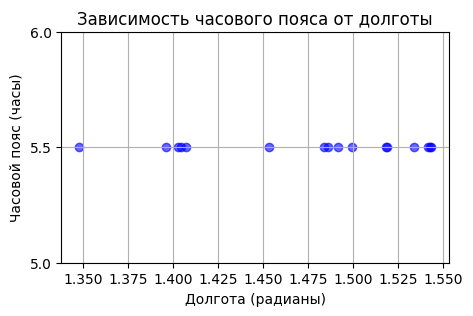

In [34]:
# !pip install matplotlib
import matplotlib.pyplot as plt

# Преобразуем объекты Time в дробные часы
def time_to_float(time_obj):
    return time_obj.hours + time_obj.minutes / 60

# Списки долготы и часовых поясов
longitudes = [city.lon for city in AllCitiesWithCountryCity]
timezones = [time_to_float(city.timeZone) for city in AllCitiesWithCountryCity]

# Построение графика
plt.figure(figsize=(5, 3))
plt.scatter(longitudes, timezones, color='blue', alpha=0.6)
plt.title("Зависимость часового пояса от долготы")
plt.xlabel("Долгота (радианы)")
plt.yticks([x / 2 for x in range(10, 13)])
plt.ylabel("Часовой пояс (часы)")
plt.grid(True)
plt.show()


In [28]:
# Радиан в одном часовом поясе (30 мин)
math.radians(360/48)

0.1308996938995747

Получаетется, что часовой пояс должен был измениться хотя бы один раз, но этого не произошло. Корреляция между долготой города и его часовым поясом не прослеживается. По долготе нельзя однозначно определить часовой пояс

In [29]:
def republicSunActivitiTime(republic, timeZone):
    republicInTimeZone = [city for city in republic if city.timeZone == timeZone]
    if len(republicInTimeZone) <= 1:
        print(f"В Временной зоне {timeZone} меньше двух городов")
        return

    sunriseTimes = [city.sunriseTime for city in republicInTimeZone]
    sunsetTimes = [city.sunsetTime for city in republicInTimeZone]
    
    print(f"Анализ временной зоны {timeZone} в республике {republicInTimeZone[0].republic}:")
    print("\tМинимальное время восхода:", min(sunriseTimes))
    print("\tМаксимальное время восхода:", max(sunriseTimes))
    print("\tСреднее время восхода:", Time.average(sunriseTimes))
    print()
    print("\tМинимальное время захода:", min(sunsetTimes))
    print("\tМаксимальное время захода:", max(sunsetTimes))
    print("\tСреднее время захода:", Time.average(sunsetTimes))

In [30]:
republicSunActivitiTime(republic1Cities, Time(5, 30))

Анализ временной зоны 05:30 в республике Андхра-Прадеш:
	Минимальное время восхода: 05:49
	Максимальное время восхода: 07:36
	Среднее время восхода: 06:17

	Минимальное время захода: 17:42
	Максимальное время захода: 19:06
	Среднее время захода: 18:06


In [31]:
republicSunActivitiTime(republic2Cities, Time(5, 30))

Анализ временной зоны 05:30 в республике Бихар:
	Минимальное время восхода: 05:37
	Максимальное время восхода: 07:17
	Среднее время восхода: 06:01

	Минимальное время захода: 17:24
	Максимальное время захода: 18:32
	Среднее время захода: 17:41


In [32]:
republicSunActivitiTime(republic3Cities, Time(5, 30))

Анализ временной зоны 05:30 в республике Западная Бенгалия:
	Минимальное время восхода: 05:32
	Максимальное время восхода: 07:05
	Среднее время восхода: 05:53

	Минимальное время захода: 17:15
	Максимальное время захода: 18:18
	Среднее время захода: 17:30


Хоть временная зона и одинаковая, время восхода и захода между городами может отличаться более, чем на 2 часа. Как например врем восхода в последеней из рассматриваемх республик

## Анализ структур данных

🔒 Неизменяемые (protected / read-only) атрибуты
| Атрибут             | Почему защищён                                                                                                                                                                                                                                                                                                                     |
| ------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **`lat`** (широта)  | Это **географическая координата**, физическое положение города на земной поверхности. При анализе данных (плотность населения, часовые пояса, расстояния и т.д.) эта величина **не должна меняться**. Если её случайно изменить, то все расчёты (долготы, карты, расстояния, солнечные времена) станут некорректными.              |
| **`lon`** (долгота) | Та же логика, что и с широтой: долгота — географическая константа. Её нельзя менять “по ошибке” в коде или при переборе данных.                                                                                                                                                                                                    |
| **`timeZone`**      | Часовой пояс определяется местоположением города. При анализе мы можем рассчитывать разницу во времени, определять солнечные события и т.д. — и если кто-то случайно изменит `timeZone`, данные “съедут” на несколько часов. Поэтому лучше разрешить менять только при создании объекта (например, если в исходных данных ошибка). |
| **`sunriseTime`**   | Это **физическое свойство местности** (время восхода), зависящее от географических координат и даты. В рамках одной модели анализа обычно рассматривается один день, и это значение не должно случайно измениться при обработке массива данных.                                                                                    |
| **`sunsetTime`**    | Аналогично `sunriseTime`: логично хранить его как неизменяемый параметр для текущего анализа. Изменять можно только при пересчёте на другую дату, а не вручную.                                                                                                                                                                    |

🧩 Почему остальные — изменяемые
| Атрибут                 | Почему можно менять                                                                                                                                                                              |
| ----------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **`title`**             | Название города может корректироваться при загрузке данных (например, “Москва” → “Moscow”). Это **метаданные**, их изменение не ломает аналитику.                                                |
| **`republic`**          | Иногда в данных встречаются разные варианты названий субъектов (“Республика Татарстан” / “Татарстан”), и нужно иметь возможность исправить.                                                      |
| **`isCapital`**         | Флаг — удобно менять при фильтрации или переопределении данных (например, если используем другой уровень административного деления).                                                             |
| **`populationDensity`** | Это аналитический показатель, часто пересчитываемый при обновлении данных (например, “население/площадь”). Он не является физически постоянным свойством города, поэтому должен быть изменяемым. |

| Категория                | Атрибуты                                              | Статус     |
| ------------------------ | ----------------------------------------------------- | ---------- |
| 🔒 Физические константы  | `lat`, `lon`, `timeZone`, `sunriseTime`, `sunsetTime` | read-only  |
| 🔧 Мета- и аналитические | `title`, `republic`, `isCapital`, `populationDensity` | изменяемые |


In [35]:
capitalOfCountry.lon = 123

AttributeError: can't set attribute